# Short Notebook 1

### Group 17

Noé HIRSCHAUER - id 105716

Hugo KERINO - id 105478



Use this notebook to reproduce the results of best prediction 1 (public score : 155.972104)

#### Libraries and options

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
import warnings

from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold
import time

%matplotlib inline
sns.set_style("ticks")

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

starting_directory = 'C:/Users/NOE/source/repos/Energy-forecasting-NTNU/data/'
os.chdir(starting_directory)

warnings.filterwarnings("ignore", category=FutureWarning)

RANDOM_SEED = 59

---

## Functions

This section contains all the functions that are used for further data analysis/processing


In [7]:
def read_data_location(location: str):
    """
    Description
    -----------
    Read data from Parquet files located in a specified directory.

    This function reads the training target, observed training data, estimated training data,
    and estimated test data from Parquet files located in the specified directory.
    
    Parameters
    ----------
    - `location` (str): The directory path where the Parquet files are located.

    Returns
    -------
    - A tuple containing the following DataFrames:
      - `train_target` (pandas.DataFrame): Training target data.
      - `X_train_observed` (pandas.DataFrame): Observed training data.
      - `X_train_estimated` (pandas.DataFrame): Estimated training data.
      - `X_test_estimated` (pandas.DataFrame): Estimated test data.

    Example
    -------
    ```python
    data_location = '/path/to/data_directory'
    train_target, X_train_observed, X_train_estimated, X_test_estimated = read_data_location(data_location)
    ```
    """
    train_target = pd.read_parquet(location+'/train_targets.parquet')
    X_train_observed = pd.read_parquet(location+'/X_train_observed.parquet')
    X_train_estimated = pd.read_parquet(location+'/X_train_estimated.parquet')
    X_test_estimated = pd.read_parquet(location+'/X_test_estimated.parquet')
    return(train_target, X_train_observed, X_train_estimated, X_test_estimated)



def find_low_correlation_columns(dataframe, threshold, verbose = True):
    """
    Description
    -----------
    Find and remove columns in a DataFrame with low absolute correlation coefficients.

    This function calculates the pairwise correlation coefficients between columns in a DataFrame and
    removes columns that have absolute correlation coefficients equal to or above the specified threshold.
    It provides the option to print the removed columns for reference.

    Parameters
    ----------
    - `dataframe` (pandas.DataFrame): The DataFrame for which low correlation columns should be found.
    - `threshold` (float): The threshold for absolute correlation coefficients. Columns with absolute
                      correlation coefficients greater than or equal to this threshold will be removed.
    - `verbose` (bool, optional): If True, print information about removed columns. Default is True.

    Returns
    -------
    - List of column names that remain in the DataFrame after removing low correlation columns.

    Example
    -------
    ```python
    import pandas as pd

    data = {'feature1': [1, 2, 3, 4, 5],
            'feature2': [2, 3, 4, 5, 6],
            'feature3': [5, 6, 7, 8, 9]}

    df = pd.DataFrame(data)
    threshold = 0.7

    selected_columns = find_low_correlation_columns(df, threshold)
    ```
    """
    
    correlation_matrix = dataframe[:].corr()

    feature_list = list(correlation_matrix.columns)
    removed_list = []
    for reference_index in range(len(feature_list)):
        reference_feature = feature_list[reference_index]

        # Check if this feature has not already been removed
        if reference_feature not in removed_list:
            for compared_index in range(reference_index+1,len(feature_list)):
                compared_feature = feature_list[compared_index]

                # Check if this feature has not already been removed
                if compared_feature not in removed_list:

                    # Get correlation coefficient
                    coefficient = correlation_matrix.loc[reference_feature,compared_feature]

                    # Remove column if it's a NaN
                    if pd.isna(coefficient):
                        removed_list.append(compared_feature)
                        if verbose : print(f"Removed {compared_feature} because it is NaN")
                        
                    # Remove if it is above threshold
                    if np.abs(coefficient)>=threshold:
                        removed_list.append(compared_feature)
                        if verbose : print(f"Removed \t{compared_feature}\tbecause it is correlated to\t{reference_feature}")
    
    
    output_list = feature_list.copy()
    for element in removed_list:
        output_list.remove(element)
        
    return list(output_list)





def fill_nan(Dataframe: pd.DataFrame, feature: str, verbose: bool = True):
    """
    Description
    -----------
    Fill missing (`NaN`) values in a specified feature of a DataFrame using forward-fill or backward-fill.

    This function checks for missing values in the specified feature and fills them using forward-fill (`ffill`)
    or backward-fill (`bfill`) if necessary. It also provides information about the filled method and missing data.

    Parameters
    ----------
    - `Dataframe` (pandas.DataFrame): The DataFrame containing the feature with missing values.
    - `feature` (str): The name of the feature in the DataFrame.
    - `verbose` (bool): whether to display information about the column being filled and the method used

    Returns
    -------
    - None, but it updates the input DataFrame in place by filling missing values.

    Example
    -------
    ```python
    import pandas as pd

    data = {'date': pd.date_range(start='2023-01-01', periods=100, freq='D'),
            'value': [1, 2, np.nan, 4, np.nan, 6, 7, 8, np.nan, 10]}

    df = pd.DataFrame(data)
    feature = 'value'

    fill_nan(df, feature)
    ```
    """
    it_na = np.where(Dataframe[feature].isna())[0]
    
    #If missing value
    if len(it_na != 0):
        if verbose:
            print("Missing data in",feature," size ",it_na.size," out of", Dataframe.shape[0])
        new_column = Dataframe[feature].ffill()
        method = 'ffill'
        
        if((np.any(new_column.isna()) == True)): 
            method = 'bfill'
            new_column = Dataframe[feature].bfill()
    
        if (np.any(new_column.isna()) == False):
            if verbose:
                print("Filled with",method,"method")
            Dataframe[feature] = new_column
        else:
            if verbose:
                print("WARNING : still NaN values in "+feature)

def load_clean_datasets(location: str, threshold: float,verbose=True):
    """
    Description
    -----------
    Load and preprocess datasets, handling missing values and highly correlated features.

    This function loads four datasets from the specified location and processes them. It replaces colons in column names,
    identifies low-correlation features, and fills missing values using the `fill_nan` function.

    Parameters
    ----------
    - `location` (str): The path or URL to the data files.
    - `threshold` (float): The threshold for feature correlation identification.
    - `verbose` (bool): whether to display information about the dataset being processed

    Returns
    -------
    - Tuple of DataFrames: A tuple containing four DataFrames for train_target, X_train_observed, X_train_estimated, and X_test_estimated.
    - List of Lists of str: A list of lists containing the names of low-correlation features for each DataFrame.

    Example
    -------
    ```python
    train_target, X_train_observed, X_train_estimated, X_test_estimated, FEATURES = load_clean_datasets("data/location", 0.7)
    ```
    """
    train_target, X_train_observed, X_train_estimated, X_test_estimated = read_data_location(location = location)


    # Process NaNs and highly correlated features
    dataframes = [train_target,X_train_observed,X_train_estimated,X_test_estimated]
    dataframe_names = ["train_target","X_train_observed","X_train_estimated","X_test_estimated"]
    index = 0
    FEATURES = [] # Contains the list of useful features for each dataframe


    for dataframe in dataframes:
        if verbose:
            print("** WORKING ON "+dataframe_names[index]+"**")
        # Replace colons with underscores in column names of 'dataframe'
        dataframe.columns = dataframe.columns.str.replace(':', '_')
        # Find low find_low_correlation_columns
        features = find_low_correlation_columns(dataframe,threshold,verbose=False)
        FEATURES.append(features)
        # Fill NaN
        for feature in dataframe.columns:
            fill_nan(dataframe,feature,verbose=False)
        index+=1
    return (train_target, X_train_observed, X_train_estimated, X_test_estimated,FEATURES)

def select_and_resample(Xdf: pd.DataFrame,Ydf: pd.DataFrame):
    """
    Description
    -----------
    Select and resample time series data.

    This function selects data from two time series dataframes, `Xdf` and `Ydf`, where there is a match in time values.
    It then resamples `Ydf` to a 15-minute interval using linear interpolation and returns the resulting time-aligned data.
    The output data contains only streaks of minutes `[15, 30, 45, 00]`.

    Parameters
    ----------
    - `Xdf` (pandas.DataFrame): The first time series dataframe containing `'date_forecast'` column.
    - `Ydf` (pandas.DataFrame): The second time series dataframe containing `'time'` column.

    Returns
    -------
    - Tuple of two pandas DataFrames:
      - The selected and filtered X values, with a 15-minute interval.
      - The resampled Y values, matching the selected X values.

    Example
    -------
    ```python
    Xdf = pd.DataFrame({'date_forecast': pd.date_range(start='2023-01-01', periods=100, freq='15T')})
    Ydf = pd.DataFrame({'time': pd.date_range start='2023-01-01', periods=200, freq='30T')})
    selected_X, selected_Y = select_and_resample(Xdf, Ydf)
    ```
    """
    
    ##### Select Y values where there are X values :
    Y_in_X_times = Ydf['time'].isin(Xdf['date_forecast'])
    Selected_Y = Ydf[Y_in_X_times].reset_index(drop=True)
    
    ##### Select X values where there are Y values
    # ceil the date forecast to the hour in Xdf
    Xdf['hourly_forecast'] = Xdf['date_forecast'].dt.ceil('H')
    X_in_Y_times = Xdf['hourly_forecast'].isin(Selected_Y['time'])
    Selected_X = Xdf[X_in_Y_times].reset_index(drop=True).drop(columns=['hourly_forecast'])

    #### Filter X values to get 4 consecutive 15 minutes
    valid_minutes = [15, 30, 45, 0]
    # Calculate the difference in minutes between consecutive rows
    Selected_X = Selected_X.sort_values('date_forecast')
    Selected_X['minute_diff'] = Selected_X['date_forecast'].diff().dt.total_seconds() / 60
    # Create a mask to identify valid minutes
    valid_mask = Selected_X['minute_diff'].isin(valid_minutes)
    # Create a mask to identify the start of consecutive valid minute streaks
    streak_start_mask = valid_mask & (~valid_mask.shift(1, fill_value=False))
    # Create a mask to identify the end of consecutive valid minute streaks
    streak_end_mask = valid_mask & (~valid_mask.shift(-1, fill_value=False))
    # Merge the start and end masks to get the full streak mask
    consecutive_streak_mask = streak_start_mask | streak_end_mask
    # Extend the streaks to include isolated values
    consecutive_streak_mask = consecutive_streak_mask | consecutive_streak_mask.shift(1, fill_value=False) | consecutive_streak_mask.shift(-1, fill_value=False)
    # Repeatedly extend the streaks until no more can be extended
    while True:
        extended_streaks = consecutive_streak_mask | consecutive_streak_mask.shift(1, fill_value=False) | consecutive_streak_mask.shift(-1, fill_value=False)
        if extended_streaks.equals(consecutive_streak_mask):
            break
        consecutive_streak_mask = extended_streaks
    # Identify the cases where the streaks start with non-15 minutes
    non_15_start = valid_mask & (streak_start_mask | streak_end_mask)
    consecutive_streak_mask = consecutive_streak_mask | non_15_start

    Selected_X_filtered = Selected_X[consecutive_streak_mask].drop(columns='minute_diff')

    #### Resample Ydf with 15 minute interval 
    Selected_Y.set_index('time', inplace=True)
    Selected_Y_resampled = Selected_Y.resample('15T').interpolate(method='linear') #  use 'nearest' for flatter interpolation
    Selected_Y_resampled = Selected_Y_resampled.reset_index()

    # Select Y resampled values where there are X values :
    Y_in_X_times_resampled = Selected_Y_resampled['time'].isin(Selected_X_filtered['date_forecast'])
    Selected_Y = Selected_Y_resampled[Y_in_X_times_resampled].reset_index(drop=True)
    # Again the other way round to remove data that passed through the filter
    Selected_X = Selected_X_filtered[Selected_X_filtered['date_forecast'].isin(Selected_Y['time'])].reset_index(drop=True)


    return(Selected_X[1:], Selected_Y[1:])  # remove first row which always starts with a 00

def remove_consecutive_identical_values(df: pd.DataFrame, feature: str):
    """
    Description
    -----------
    Remove rows with consecutive identical values in a specified feature of a DataFrame.

    Paramters
    ---------
    - `df` (pandas.DataFrame): The DataFrame to process.
    - `feature` (str): The name of the feature in the DataFrame.

    Returns
    -------
    - `pandas.DataFrame`: The filtered DataFrame with consecutive identical values removed.

    Example
    -------
    ```python
    import pandas as pd

    data = {'time': pd.date_range(start='2023-01-01', periods=100, freq='15T'),
            'value': [1, 2, 2, 3, 3, 3, 4, 4, 4, 4]}

    df = pd.DataFrame(data)
    feature = 'value'

    filtered_df = remove_consecutive_identical_values(df, feature)
    ```
    """
    # Identify rows with consecutive identical values in the specified feature
    mask = df[feature] != df[feature].shift(+1)

    # Filter and remove rows with consecutive identical values
    filtered_df = df[mask]

    return filtered_df


def select_o_clock(dataframe: pd.DataFrame, feature: str) -> pd.DataFrame:
    """
    Description
    -----------
    Select rows from a DataFrame where the time in the specified feature is a round hour (minute and second are 0) and sort them by the 'feature' column.

    Parameters
    ----------
    - `dataframe` (pandas.DataFrame): The DataFrame to process.
    - `feature` (str): The name of the feature column containing time values.

    Returns
    -------
    - `pandas.DataFrame`: The filtered DataFrame with rows where the time is a round hour, sorted by the 'feature' column.

    Example
    -------
    ```python
    import pandas as pd

    data = {'time_column': pd.date_range(start='2023-01-01', periods=100, freq='H')}

    df = pd.DataFrame(data)
    feature = 'time_column'

    filtered_df = select_o_clock(df, feature)
    ```
    """
     # Check if the feature column exists in the DataFrame
    if feature not in dataframe.columns:
        raise ValueError(f"'{feature}' column not found in the DataFrame")

    # Check if the feature column is of datetime type
    if not pd.api.types.is_datetime64_any_dtype(dataframe[feature]):
        raise ValueError(f"'{feature}' column should be of datetime type")

    # Filter the DataFrame to select rows with round-hour times
    filtered_df = dataframe[dataframe[feature].dt.minute == 0 & (dataframe[feature].dt.second == 0)]
    
    # Sort the filtered DataFrame by the 'feature' column
    filtered_df = filtered_df.sort_values(by=feature)

    return filtered_df


def lagged_features(df, time_intervals = [15,30,45],verbose=False):
    """
    Description
    -----------
    Generate lagged features in a DataFrame based on specified time intervals.

    This function creates lagged features for selected columns in the DataFrame by shifting the data back in time based on
    the provided time intervals. It then fills in missing values using the `fill_nan` function.

    Parameters
    ----------
    - `df` (pandas.DataFrame): The DataFrame to which lagged features will be added.
    - `time_intervals` (List[int]): List of time intervals (in minutes) for creating lagged features.
    - `verbose` (bool): Whether to display information about the lagged features being created.

    Returns
    -------
    - pandas.DataFrame: A new DataFrame with lagged features added and missing values filled.

    Example
    -------
    ```python
    data = {'date_forecast': pd.date_range(start='2023-01-01', periods=100, freq='H'),
            'value1': [1, 2, 3, 4, 5],
            'value2': [10, 20, 30, 40, 50]}

    df = pd.DataFrame(data)
    time_intervals = [15, 30, 45]

    lagged_df = lagged_features(df, time_intervals)
    ```
    """

    if time_intervals==0:
        return df
    
    new_df = df.copy()      
    new_columns = []

    for interval in time_intervals:
        # Create a suffix for the column names
        suffix = '__r' + str(interval)

        lagged_df = new_df.shift(interval//15).copy()

        for column in df.columns:
            if column not in ['date_forecast', 'date_calc','sin_year','cos_year']:
                lag_name=column + suffix
                if verbose: print(lag_name)
                # Add lagged column
                new_column = pd.DataFrame()
                new_column[lag_name] = new_df[column].copy()
                # Get the value at the shifted time
                mask = (new_df['date_forecast']-pd.to_timedelta(interval, unit='minutes') == lagged_df['date_forecast'])
                new_column.loc[mask,lag_name] = lagged_df.loc[mask,column]
                # Fix values where there is no data available
                new_column.loc[np.logical_not(mask),lag_name]=np.nan
                new_columns.append(new_column)

    new_df = pd.concat([new_df]+new_columns,axis=1)

    # Fill missing values with the last known value for each specific column
    for column in new_df.columns:
        fill_nan(new_df,column,verbose=False)
    
    return new_df


def lagged_features_FUTURE(df, time_intervals = [15,30,45],verbose=False):
    """
    Description
    -----------
    Generate lagged features in a DataFrame based on specified time intervals.

    This function creates lagged features for selected columns in the DataFrame by shifting the data back in time based on
    the provided time intervals. It then fills in missing values using the `fill_nan` function.

    Parameters
    ----------
    - `df` (pandas.DataFrame): The DataFrame to which lagged features will be added.
    - `time_intervals` (List[int]): List of time intervals (in minutes) for creating lagged features.
    - `verbose` (bool): Whether to display information about the lagged features being created.

    Returns
    -------
    - pandas.DataFrame: A new DataFrame with lagged features added and missing values filled.

    Example
    -------
    ```python
    data = {'date_forecast': pd.date_range(start='2023-01-01', periods=100, freq='H'),
            'value1': [1, 2, 3, 4, 5],
            'value2': [10, 20, 30, 40, 50]}

    df = pd.DataFrame(data)
    time_intervals = [15, 30, 45]

    lagged_df = lagged_features(df, time_intervals)
    ```
    """

    if time_intervals==0:
        return df
    
    new_df = df.copy()      
    new_columns = []

    for interval in time_intervals:
        # Create a suffix for the column names
        suffix = '__p' + str(interval)

        lagged_df = new_df.shift(-interval//15).copy()

        for column in df.columns:
            if column not in ['date_forecast', 'date_calc','sin_year','cos_year']:
                lag_name=column + suffix
                if verbose: print(lag_name)
                # Add lagged column
                new_column = pd.DataFrame()
                new_column[lag_name] = new_df[column].copy()
                # Get the value at the shifted time
                mask = (new_df['date_forecast']+pd.to_timedelta(interval, unit='minutes') == lagged_df['date_forecast'])
                new_column.loc[mask,lag_name] = lagged_df.loc[mask,column]
                # Fix values where there is no data available
                new_column.loc[np.logical_not(mask),lag_name]=np.nan
                new_columns.append(new_column)

    new_df = pd.concat([new_df]+new_columns,axis=1)

    # Fill missing values with the last known value for each specific column
    for column in new_df.columns:
        fill_nan(new_df,column,verbose=False)
    
    return new_df



def normalize_dataframe_minmax(df: pd.DataFrame,verbose = False):
    """
    Description
    -----------
    Normalize a DataFrame using min-max scaling, excluding datetime columns.

    This function performs min-max scaling to normalize each column in the DataFrame between 0 and 1,
    excluding datetime columns. It replaces the original values with the scaled values.

    Parameters
    ----------
    - `df` (pandas.DataFrame): The DataFrame to be normalized.
    - `verbose` (bool): Whether to display information about the columns being normalized.

    Returns
    -------
    - pandas.DataFrame: A new DataFrame with columns normalized between -1 and 1.

    Example
    -------
    ```python
    data = {'feature1': [1, 2, 3, 4, 5],
            'feature2': [10, 20, 30, 40, 50],
            'date': pd.date_range(start='2023-01-01', periods=5, freq='D')}

    df = pd.DataFrame(data)

    normalized_df = normalize_dataframe(df)
    ```
    """
    normalized_df = df.copy()
    # Define the range [0, 1]
    min_range = 0
    max_range = 1
    
    # Iterate over each column and apply min-max scaling, excluding datetime columns
    for column in normalized_df.columns:
        if verbose:
            print(column)
        if normalized_df[column].dtype not in [pd.Timestamp, pd.DatetimeTZDtype,'<M8[us]']:
            min_val = normalized_df[column].min()
            max_val = normalized_df[column].max()
            if verbose:
                print(f"min:{min_val:.2f}\tmax:{max_val:.2f}")
                print(f"different:{min_val!=max_val}")
            # Normalize the non-datetime column between -1 and 1
            if min_val!=max_val:
                normalized_df[column] = min_range + (max_range - min_range) * (normalized_df[column] - min_val) / (max_val - min_val)
            else :
                normalized_df[column] = min_range + (max_range - min_range) * normalized_df[column]/max(max_val,1)

    return normalized_df

def normalize_dataframe_minmax_TEST(train_df: pd.DataFrame,test_df: pd.DataFrame,verbose = False):

    normalized_train = train_df.copy()
    normalized_test = test_df.copy()
    # Define the range [0, 1]
    min_range = 0 # best 0
    max_range = 1
    
    # Iterate over each column and apply min-max scaling, excluding datetime columns
    for column in train_df.columns:
        if verbose:
            print(column)
        if train_df[column].dtype not in [pd.Timestamp, pd.DatetimeTZDtype,'<M8[us]']:
            min_val = min(train_df[column].min(),test_df[column].min())
            max_val = max(train_df[column].max(),test_df[column].max())
            if verbose:
                print(f"min:{min_val:.2f}\tmax:{max_val:.2f}")
                print(f"different:{min_val!=max_val}")
            # Normalize the non-datetime column between -1 and 1
            if min_val!=max_val:
                normalized_train[column] = min_range + (max_range - min_range) * (normalized_train[column] - min_val) / (max_val - min_val)
                normalized_test[column] = min_range + (max_range - min_range) * (normalized_test[column] - min_val) / (max_val - min_val)
            else :
                normalized_train[column] = min_range + (max_range - min_range) * normalized_train[column]/max(max_val,1)
                normalized_test[column] = min_range + (max_range - min_range) * normalized_test[column]/max(max_val,1)

    return (normalized_train, normalized_test)

def normalize_dataframe_mean_std(df: pd.DataFrame,verbose = False):
    """
    Description
    -----------
    Normalize a DataFrame using mean and standard deviation scaling.

    This function performs mean and standard deviation scaling to normalize each column in the DataFrame using the
    mean and standard deviation values calculated from the same DataFrame.

    Parameters
    ----------
    - `df` (pandas.DataFrame): The DataFrame to be normalized.
    - `verbose` (bool): Whether to display information about the columns being normalized.

    Returns
    -------
    - pandas.DataFrame: A new DataFrame with columns normalized based on mean and standard deviation values.

    Example
    -------
    ```python
    import pandas as pd

    data = {'feature1': [1, 2, 3, 4, 5],
            'feature2': [10, 20, 30, 40, 50]}

    df = pd.DataFrame(data)

    normalized_df = normalize_dataframe_mean_std(df)
    ```
    """

    normalized_df = df.copy()

    # Iterate over each column and apply mean/std scaling, excluding datetime columns
    for column in normalized_df.columns:
        if verbose:
            print(column)
        if normalized_df[column].dtype not in [pd.Timestamp, pd.DatetimeTZDtype,'<M8[us]']:
            mean = normalized_df[column].mean()
            std = normalized_df[column].std()
            if verbose:
                print(f"mean:{mean:1f} \tstd:{std:.1f}")
            if std!=0:
                normalized_df[column] = (normalized_df[column] - mean) / std
            else :
                normalized_df[column] = (normalized_df[column] - mean) / 1

    return normalized_df



def normalize_dataframe_mean_std_TEST(train_df: pd.DataFrame,test_df: pd.DataFrame,verbose = False):
    """
    Description
    -----------
    Normalize a test DataFrame using mean and standard deviation scaling, based on statistics from a training DataFrame.

    This function performs mean and standard deviation scaling to normalize each column in the test DataFrame using the
    mean and standard deviation values from the corresponding columns in the training DataFrame.

    Parameters
    ----------
    - `train_df` (pandas.DataFrame): The training DataFrame used to calculate mean and standard deviation statistics.
    - `test_df` (pandas.DataFrame): The test DataFrame to be normalized.
    - `verbose` (bool): Whether to display information about the columns being normalized.

    Returns
    -------
    - pandas.DataFrame: A new DataFrame with columns in the test DataFrame normalized based on mean and standard deviation
    statistics from the training DataFrame.

    Example
    -------
    ```python
    import pandas as pd

    train_data = {'feature1': [1, 2, 3, 4, 5],
                 'feature2': [10, 20, 30, 40, 50]}
    
    test_data = {'feature1': [6, 7, 8, 9, 10],
                'feature2': [60, 70, 80, 90, 100]}
    
    train_df = pd.DataFrame(train_data)
    test_df = pd.DataFrame(test_data)
    
    normalized_test_df = normalize_dataframe_mean_std_TEST(train_df, test_df)
    ```
    """
    normalized_df = test_df.copy()

    # Iterate over each column and apply mean/std scaling, excluding datetime columns
    for column in normalized_df.columns:
        if verbose:
            print(column)
        if normalized_df[column].dtype not in [pd.Timestamp, pd.DatetimeTZDtype,'<M8[us]']:
            mean = train_df[column].mean()
            std = train_df[column].std()
            if verbose:
                print(f"mean:{mean:1f} \tstd:{std:.1f}")
            if std!=0:
                normalized_df[column] = (normalized_df[column] - mean) / std
            else :
                normalized_df[column] = (normalized_df[column] - mean) / 1

    return normalized_df


def convert_datetime(df: pd.DataFrame, time_feature: str):
    new_df = df.copy()

    # Convert the 'time_feature' column to datetime if it's not already
    new_df[time_feature] = pd.to_datetime(new_df[time_feature])

    # Calculate the number of seconds since midnight and subtract it from 86400 to make it -1 at midnight
    new_df['seconds_since_midnight'] = (new_df[time_feature] - new_df[time_feature].dt.normalize()).dt.total_seconds()

    # Calculate the sine of the day with -1 at midnight
    new_df['sin_day'] = np.sin(2 * np.pi * new_df['seconds_since_midnight']/86400- np.pi/2)

    # Calculate the sine of the year with -1 on January 1st
    new_df['sin_year'] = np.sin(2 * np.pi * (new_df[time_feature].dt.dayofyear - 1)/365 - np.pi/2)

    # Calculate the cosine of the year with -1 on January 1st
    new_df['cos_year'] = np.cos(2 * np.pi * (new_df[time_feature].dt.dayofyear - 1)/365 - np.pi/2)

    # Calculate the difference in seconds between 'time_feature' and 'date_calc'
    new_df['forecast_interval'] = (new_df[time_feature] - new_df['date_calc']).dt.total_seconds().fillna(0)

    # Drop the temporary 'seconds_since_midnight' column if you don't need it
    new_df.drop('seconds_since_midnight', axis=1, inplace=True)

    return new_df

def full_data_loader_backup(location,n_lagged_features=3,threshold=0.9,normalization = 'minmax',date_encoding=True,verbose=True):
    """
    Description
    -----------
    Load, preprocess, and prepare data for training and prediction including feature engineering, normalization, and resampling.

    This function reads datasets, selects usable data, adds date encoding features, lagged features, and normalizes the data.

    Parameters
    ----------
    - `location` (str): The path or URL to the data files.
    - `n_lagged_features` (int): The number of lagged features to add.
    - `threshold` (float): The threshold for feature correlation identification.
    - `normalization` (str): The type of data normalization ('minmax' or 'mean'), or 'none' for no normalization.
    - `date_encoding` (bool): Whether to add date encoding features.
    - `verbose` (bool): Whether to display progress and information.

    Returns
    -------
    - Tuple of DataFrames, Series, and List: A tuple containing X_Train, Y_Train, X_Test, and a list of selected features.

    Example
    -------
    ```python
    location = "data/location"
    n_lagged_features = 3
    threshold = 0.9
    normalization = 'minmax'
    date_encoding = True
    verbose = True

    X_Train, Y_Train, X_Test, selected_features = full_data_loader(
        location, n_lagged_features, threshold, normalization, date_encoding, verbose
    )
    ```
    """
    # Read datasets
    if verbose: print("Reading datasets")
    train_target, X_train_observed, X_train_estimated, X_test_estimated, FEATURES = load_clean_datasets(location, threshold,verbose=False)
    
    selected_features = FEATURES[-1][1:] # all low correlation features from X_test_estimated except date

    # Select usable data and resample training target
    if verbose: print("Selecting training data")
    Ydf = remove_consecutive_identical_values(train_target,'pv_measurement')
    Xdf = pd.concat([X_train_observed,X_train_estimated]).reset_index(drop=True)
    X_Train,Y_Train = select_and_resample(Xdf,Ydf)
    
    # Add features to encode the date information
    if date_encoding:
        if verbose: print("Encoding date information")
        X_Train = convert_datetime(X_Train,'date_forecast')
        X_Test = convert_datetime(X_test_estimated, 'date_forecast')
        selected_features += ['sin_day']
    else:
        X_Test = X_test_estimated
    
    # Add lagged features
    if n_lagged_features!=0:
        if verbose: print("Adding lag features")
        time_lags = [15*n for n in range(1,n_lagged_features+1)] # in minutes
        X_Train = lagged_features(X_Train,time_intervals=time_lags,verbose=False)
        X_Test = lagged_features(X_Test,time_intervals=time_lags,verbose=False)
        feature_list = selected_features
        suffix_list = ['']+[f"__r{lag}" for lag in time_lags]
        selected_features = [f+suffix for f in feature_list for suffix in suffix_list]

    if date_encoding:
        selected_features += ['sin_year','cos_year','forecast_interval']

    # Normalize datasets
    if normalization in ['minmax', 'mean']:
        if verbose:print("Normalizing with "+normalization)
        if normalization == 'minmax':
            # X_Train_normal = normalize_dataframe_minmax(X_Train)
            X_Train_normal,X_Test_normal = normalize_dataframe_minmax_TEST(X_Train,X_Test)
        if normalization == 'mean':
            X_Train_normal = normalize_dataframe_mean_std(X_Train)
            X_Test_normal = normalize_dataframe_mean_std_TEST(X_Train,X_Test)
        X_Train = X_Train_normal
        X_Test = X_Test_normal



    if verbose :print("\nDone\n")
    return (X_Train,Y_Train['pv_measurement'],X_Test,selected_features)

def full_data_loader(location,n_lagged_features=3,threshold=0.9,normalization = 'minmax',date_encoding=True,verbose=True):
    """
    Description
    -----------
    Load, preprocess, and prepare data for training and prediction including feature engineering, normalization, and resampling.

    This function reads datasets, selects usable data, adds date encoding features, lagged features, and normalizes the data.

    Parameters
    ----------
    - `location` (str): The path or URL to the data files.
    - `n_lagged_features` (int): The number of lagged features to add.
    - `threshold` (float): The threshold for feature correlation identification.
    - `normalization` (str): The type of data normalization ('minmax' or 'mean'), or 'none' for no normalization.
    - `date_encoding` (bool): Whether to add date encoding features.
    - `verbose` (bool): Whether to display progress and information.

    Returns
    -------
    - Tuple of DataFrames, Series, and List: A tuple containing X_Train, Y_Train, X_Test, and a list of selected features.

    Example
    -------
    ```python
    location = "data/location"
    n_lagged_features = 3
    threshold = 0.9
    normalization = 'minmax'
    date_encoding = True
    verbose = True

    X_Train, Y_Train, X_Test, selected_features = full_data_loader(
        location, n_lagged_features, threshold, normalization, date_encoding, verbose
    )
    ```
    """
    # Read datasets
    if verbose: print("Reading datasets")
    train_target, X_train_observed, X_train_estimated, X_test_estimated, FEATURES = load_clean_datasets(location, threshold,verbose=False)
    
    selected_features = FEATURES[-1][1:] # all low correlation features from X_test_estimated except date

    # Select usable data and resample training target
    if verbose: print("Selecting training data")
    Ydf = remove_consecutive_identical_values(train_target,'pv_measurement')
    Xdf = pd.concat([X_train_observed,X_train_estimated]).reset_index(drop=True)
    X_Train,Y_Train = select_and_resample(Xdf,Ydf)
    
    # Add features to encode the date information
    if date_encoding:
        if verbose: print("Encoding date information")
        X_Train = convert_datetime(X_Train,'date_forecast')
        X_Test = convert_datetime(X_test_estimated, 'date_forecast')
        selected_features += ['sin_day']
    else:
        X_Test = X_test_estimated
    
    # Add lagged features
    if n_lagged_features!=0:
        if verbose: print("Adding lag features")
        time_lags = [15*n for n in range(1,n_lagged_features+1)] # in minutes
        X_Train = lagged_features_FUTURE(X_Train,time_intervals=time_lags,verbose=False)
        X_Test = lagged_features_FUTURE(X_Test,time_intervals=time_lags,verbose=False)
        feature_list = selected_features
        suffix_list = ['']+[f"__p{lag}" for lag in time_lags]
        selected_features = [f+suffix for f in feature_list for suffix in suffix_list]

    if date_encoding:
        selected_features += ['sin_year','cos_year','forecast_interval']

    # Normalize datasets
    if normalization in ['minmax', 'mean']:
        if verbose:print("Normalizing with "+normalization)
        if normalization == 'minmax':
            # X_Train_normal = normalize_dataframe_minmax(X_Train)
            X_Train_normal,X_Test_normal = normalize_dataframe_minmax_TEST(X_Train,X_Test)
        if normalization == 'mean':
            X_Train_normal = normalize_dataframe_mean_std(X_Train)
            X_Test_normal = normalize_dataframe_mean_std_TEST(X_Train,X_Test)
        X_Train = X_Train_normal
        X_Test = X_Test_normal



    if verbose :print("\nDone\n")
    return (X_Train,Y_Train['pv_measurement'],X_Test,selected_features)

def filter_features(input_list, substring):
    return [string for string in input_list if substring in string]

## Full data loader

In [8]:
LOCATION = 'A'
n_lagged_features = 4
threshold = 0.9

# Load seleted and usable data
X_Train_full,Y_Train_full,X_Test_full,selected_features = full_data_loader(location = LOCATION,
                                                    n_lagged_features=n_lagged_features,
                                                    threshold=threshold,
                                                    normalization = 'minmax',
                                                    date_encoding=True,
                                                    verbose=False)

selected_features = filter_features(selected_features,'__p')
print(f"{len(selected_features)} features selected\n")

# Select the correct columns for the prediction
X_Train = X_Train_full[selected_features].astype('float32')
X_Test = X_Test_full[selected_features].astype('float32')
Y_Train = Y_Train_full.astype('float32')

print(f"{X_Train.shape[0]} points in the training dataset")

print(selected_features)

100 features selected

77828 points in the training dataset
['absolute_humidity_2m_gm3__p15', 'absolute_humidity_2m_gm3__p30', 'absolute_humidity_2m_gm3__p45', 'absolute_humidity_2m_gm3__p60', 'air_density_2m_kgm3__p15', 'air_density_2m_kgm3__p30', 'air_density_2m_kgm3__p45', 'air_density_2m_kgm3__p60', 'ceiling_height_agl_m__p15', 'ceiling_height_agl_m__p30', 'ceiling_height_agl_m__p45', 'ceiling_height_agl_m__p60', 'clear_sky_energy_1h_J__p15', 'clear_sky_energy_1h_J__p30', 'clear_sky_energy_1h_J__p45', 'clear_sky_energy_1h_J__p60', 'cloud_base_agl_m__p15', 'cloud_base_agl_m__p30', 'cloud_base_agl_m__p45', 'cloud_base_agl_m__p60', 'dew_or_rime_idx__p15', 'dew_or_rime_idx__p30', 'dew_or_rime_idx__p45', 'dew_or_rime_idx__p60', 'diffuse_rad_W__p15', 'diffuse_rad_W__p30', 'diffuse_rad_W__p45', 'diffuse_rad_W__p60', 'direct_rad_W__p15', 'direct_rad_W__p30', 'direct_rad_W__p45', 'direct_rad_W__p60', 'effective_cloud_cover_p__p15', 'effective_cloud_cover_p__p30', 'effective_cloud_cover_p__p

## Stacking models

For level 0 we will use CatBoost, MLP, K-neighbors and DecisionTree. The optimal parameters for each model are searched with RandomSearchCV. 
For level 1 we will use a LightGBM model that takes as input the predictions of each model as well as the corresponding inputs

In [9]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor
import lightgbm as lgb
from sklearn.ensemble import StackingRegressor

### Training loop for all locations

#### Best

In [10]:
n_lagged_features = 4
threshold = 0.9


for LOCATION in ['A','B','C']:
    print(f"\nLOCATION {LOCATION}")

    # Load seleted and usable data
    X_Train_full,Y_Train_full,X_Test_full,selected_features = full_data_loader(location = LOCATION,
                                                        n_lagged_features=n_lagged_features,
                                                        threshold=threshold,
                                                        normalization = 'minmax',
                                                        date_encoding=True,
                                                        verbose=False)
    selected_features = filter_features(selected_features,'__p') # remove features at t=0
    print(f"{len(selected_features)} features selected\n")
    
    # Select the correct columns for the prediction
    X_Train = X_Train_full[selected_features].astype('float32')
    X_Test = X_Test_full[selected_features].astype('float32')
    Y_Train = Y_Train_full.astype('float32')

    print(f"{X_Train.shape[0]} points in the training dataset")
    
    print("Training in progress")
    start = time.time()

    # Initialize the model base learners
    level0 = list()
    level0.append(('catboost', CatBoostRegressor(iterations=1000,
                            depth=9,
                            learning_rate=0.35,
                            l2_leaf_reg=6,
                            loss_function='RMSE',
                            # task_type='GPU',
                            verbose=0,
                            allow_writing_files=False)))
    level0.append(('decision_tree', DecisionTreeRegressor(splitter='random',
                                                        min_samples_split=3,
                                                        min_samples_leaf=2,
                                                        max_depth=None,
                                                        random_state=RANDOM_SEED)))
    level0.append(('k_nearest_neighbor', KNeighborsRegressor(n_neighbors=2,
                                                            leaf_size=35)))
    # define meta learner model
    level1 = lgb.LGBMRegressor(tree_learner= 'serial',
                            num_threads= 2,
                            num_leaves= 500,
                            n_estimators= 1000,
                            metric= 'mse',
                            learning_rate= 0.08,
                            verbose=0)

    # define the stacking ensemble
    model = StackingRegressor(estimators=level0,
                            final_estimator=level1,
                            passthrough=True, 
                            cv=10,
                            n_jobs=2,
                            verbose = 0)

    # fit the model on all available data
    model.fit(X_Train, Y_Train)

    # Save model
    from joblib import dump
    name = 'catboost_kneighbor_dectree_to_lgb_lag4_minmax_FUTURE_v2_'
    dump(model, 'Stacked_models/'+name + LOCATION+'.joblib')
    print(f"Training for {LOCATION} finished in {(time.time() - start)/60:.1f} minutes")


LOCATION A
100 features selected

77828 points in the training dataset
Training in progress
Training for A finished in 28.1 minutes

LOCATION B
92 features selected

53596 points in the training dataset
Training in progress
Training for B finished in 27.7 minutes

LOCATION C
112 features selected

42360 points in the training dataset
Training in progress
Training for C finished in 25.3 minutes


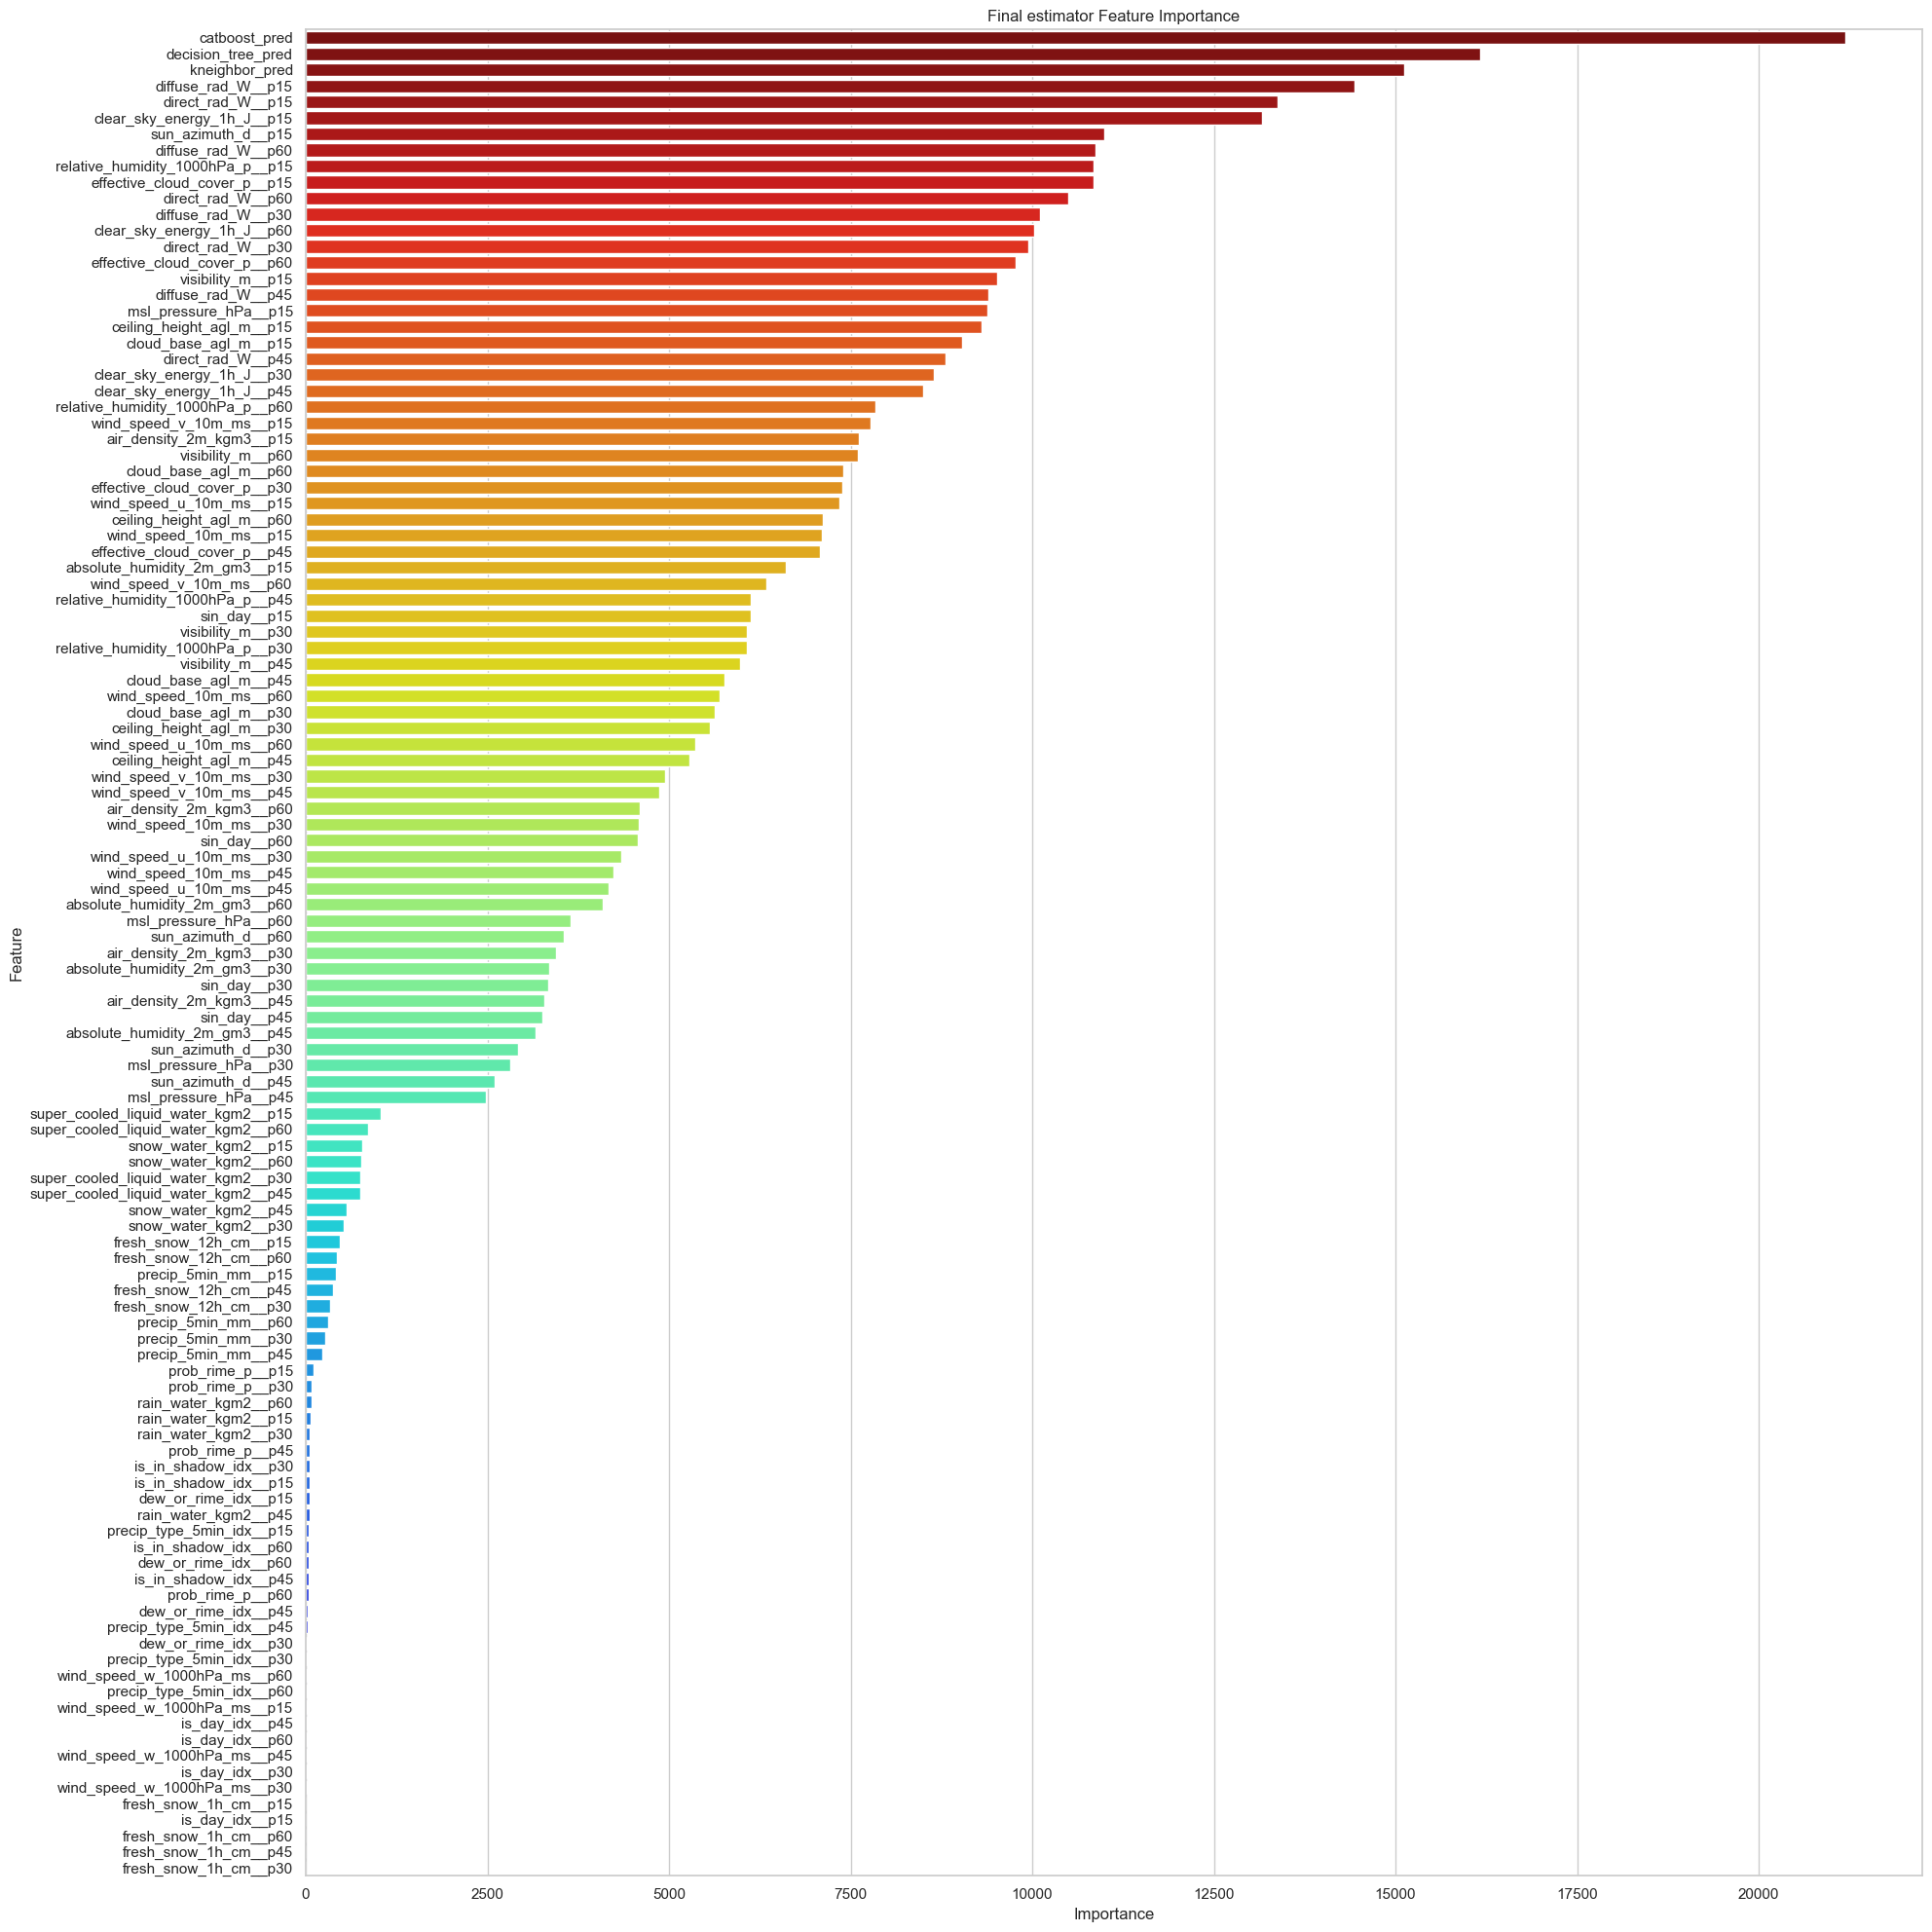

In [11]:
from joblib import load

model_name = 'catboost_kneighbor_dectree_to_lgb_lag4_minmax_FUTURE_v2_C'
importance_df = pd.DataFrame({'Feature': ['catboost_pred','decision_tree_pred','kneighbor_pred']+selected_features,
                              'Importance': model.final_estimator_.feature_importances_})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Set the style for the plot (optional)
sns.set(style="whitegrid")

# Create a barplot
plt.figure(figsize=(20, 20),dpi=100)
sns.barplot(x='Importance', y='Feature', data=importance_df, palette="jet_r", hue='Feature',width=0.8,gap=2,dodge='auto')

# Customize the plot
plt.title('Final estimator Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()

# Show the plot
plt.show()

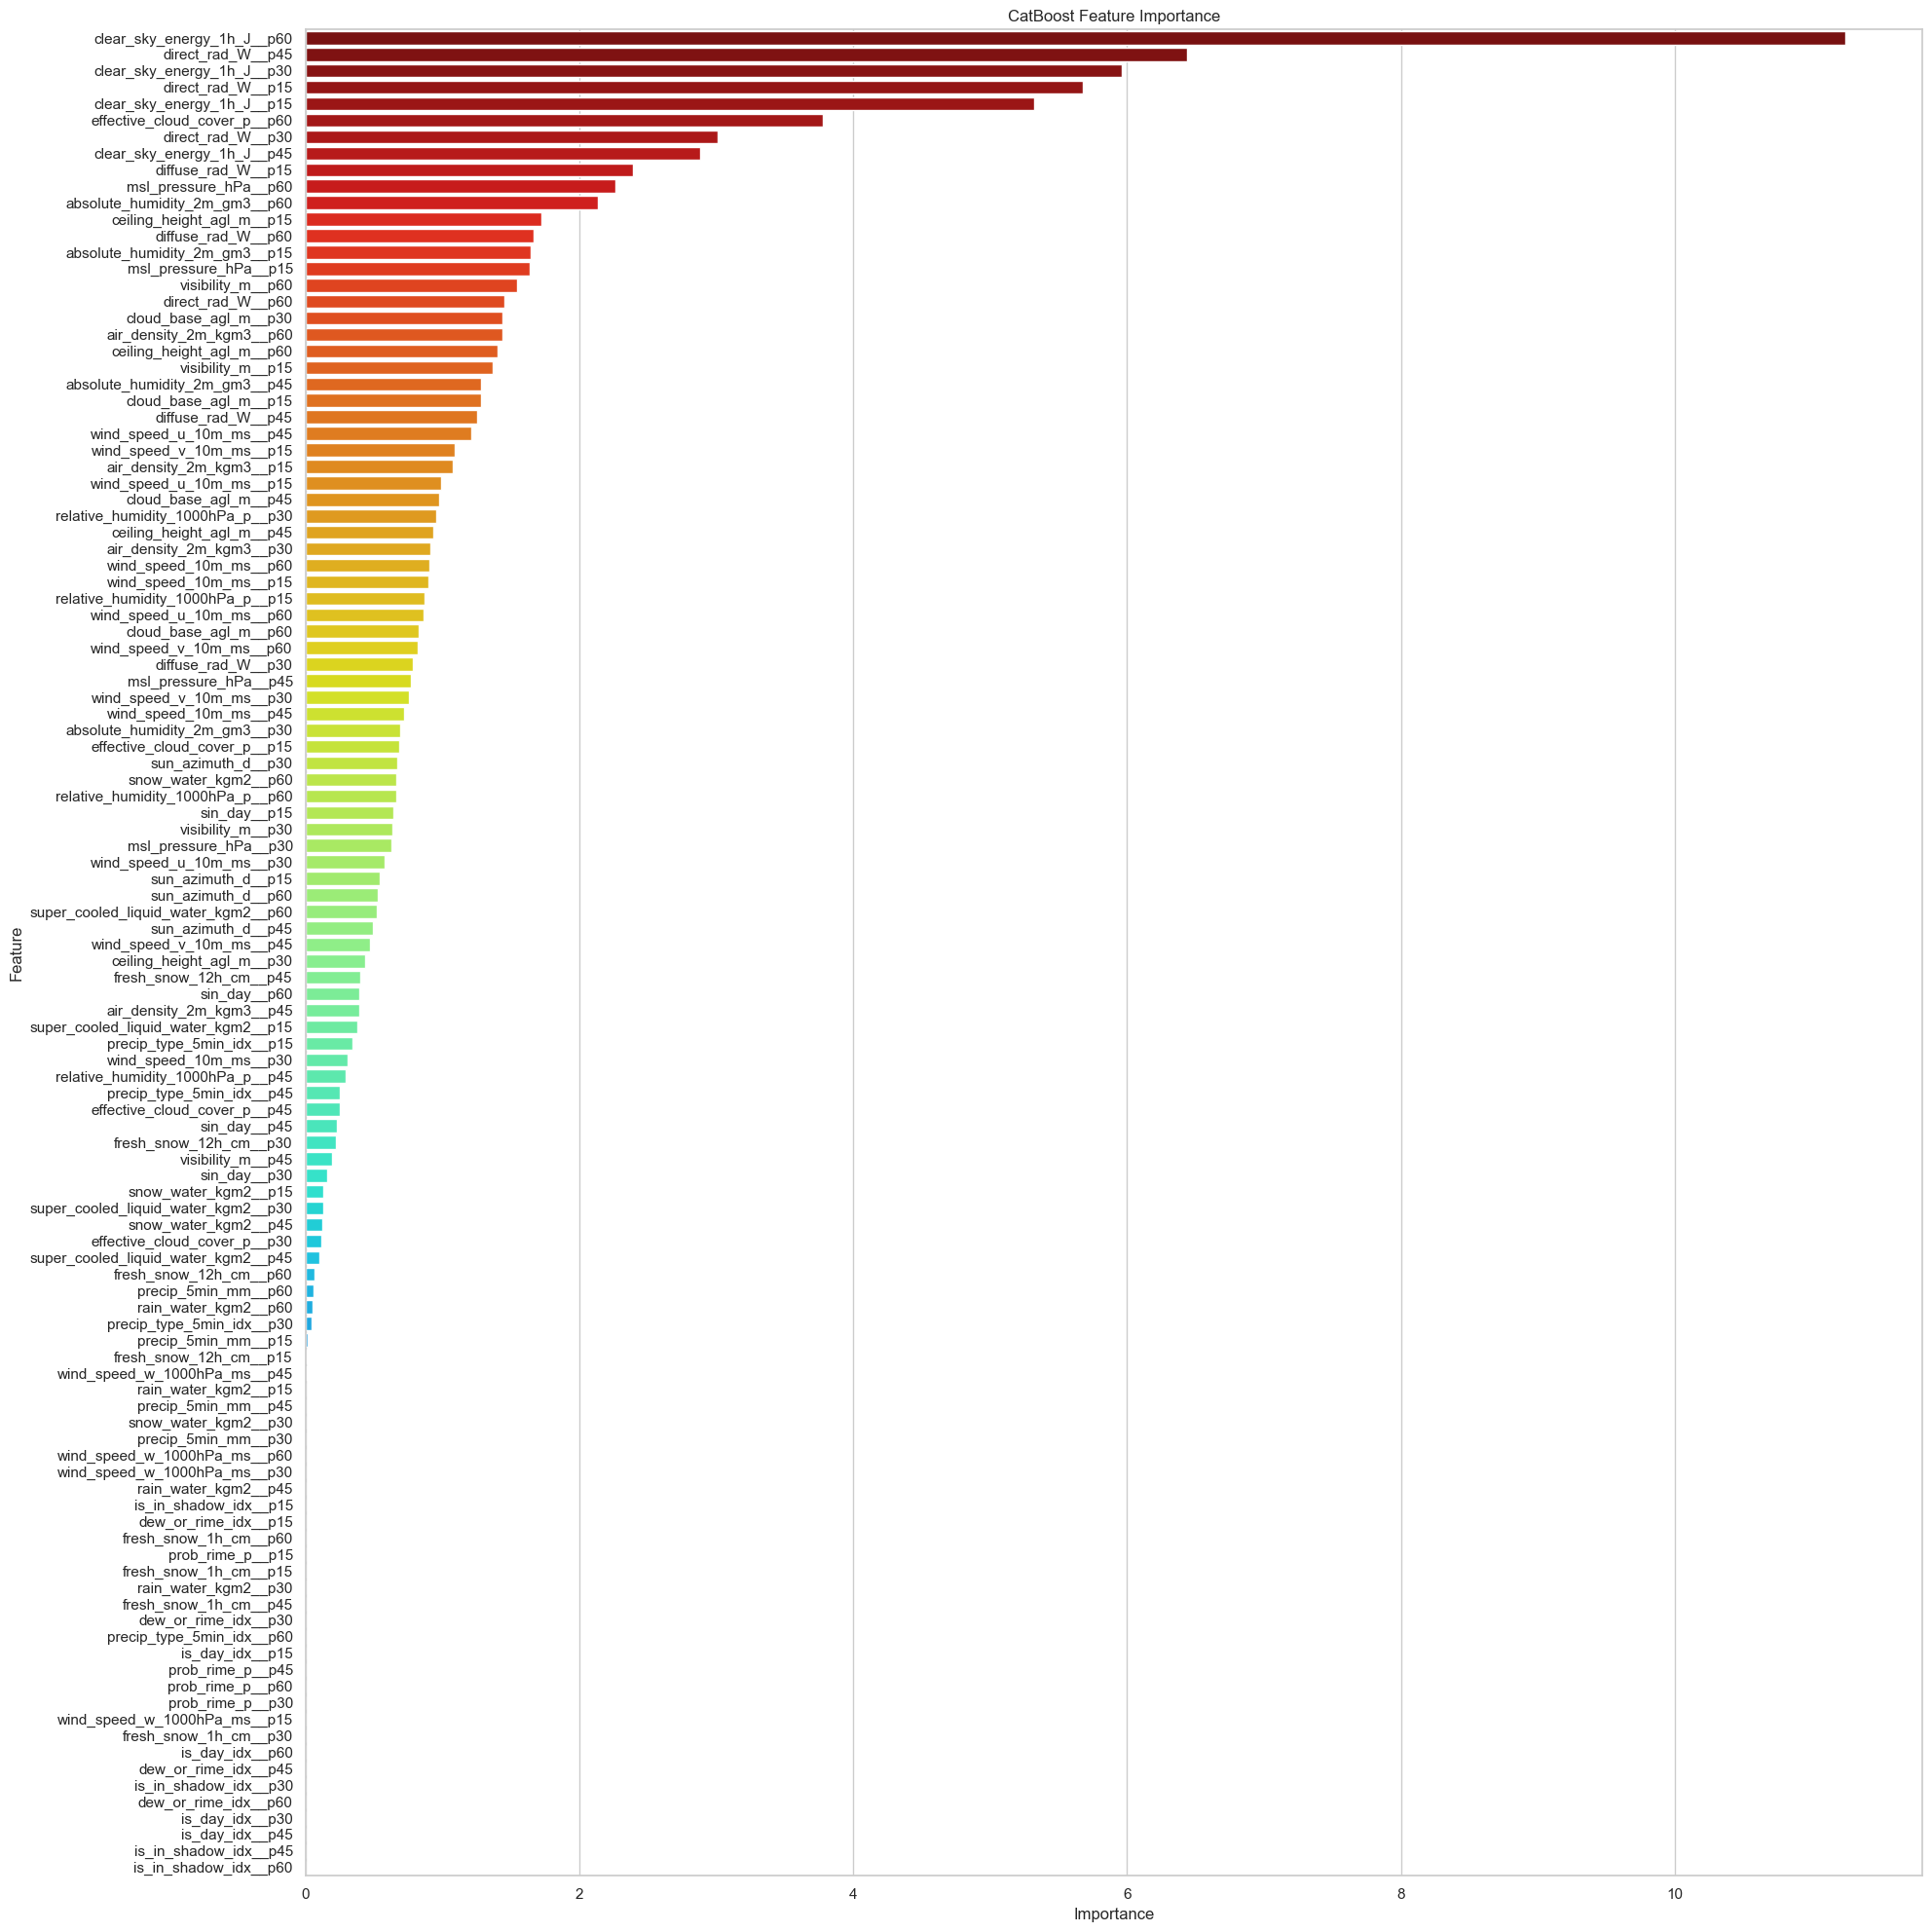

In [12]:
from joblib import load

model_name = 'catboost_kneighbor_dectree_to_lgb_lag4_minmax_FUTURE_v2_C'
catboost_model = model.estimators_[0]
feature_importances = catboost_model.get_feature_importance()
feature_names = X_Train.columns  # If your features are in a DataFrame

# Create a DataFrame to store feature names and their importances
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Set the style for the plot (optional)
sns.set(style="whitegrid")

# Create a barplot
plt.figure(figsize=(20, 20),dpi=100)
sns.barplot(x='Importance', y='Feature', data=importance_df, palette="jet_r", hue='Feature',width=0.8,gap=2,dodge='auto')

# Customize the plot
plt.title('CatBoost Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()

# Show the plot
plt.show()

## Make a prediction for Kaggle

### Loop

In [15]:
from joblib import load

PREDICTIONS = []

n_lagged_features = 4
threshold = 0.9

model_name = 'catboost_kneighbor_dectree_to_lgb_lag4_minmax_FUTURE_v2_'

for LOCATION in ['A', 'B', 'C']:
    
    print(f"\nLOCATION {LOCATION}")

    model = load('Stacked_models/'+model_name + LOCATION +'.joblib')
    # Load seleted and usable data
    X_Train_full,Y_Train_full,X_Test_full,selected_features = full_data_loader(location = LOCATION,
                                                        n_lagged_features=n_lagged_features,
                                                        threshold=threshold,
                                                        normalization = 'minmax',
                                                        date_encoding=True,
                                                        verbose=False)
    
    selected_features = filter_features(selected_features,'__p') # remove features at t=0
    
    X_Test = X_Test_full[selected_features].astype('float32')
    # Predict on the X_test_estimated dataset
    Y_test_estimated = pd.DataFrame()
    # Make predictions every 15 minutes
    pv_measurement =  model.predict(X_Test)
    pv_measurement[pv_measurement<0]=0
    Y_test_estimated['prediction'] = pv_measurement
    # Select only the predictions at round hours
    Y_test_estimated['time'] = X_Test_full['date_forecast'].reset_index(drop=True)
    Y_test_estimated_round = select_o_clock(Y_test_estimated,'time')
    PREDICTIONS.append(Y_test_estimated_round['prediction'])

# Concatenate all 3 predictions
submission = pd.concat(PREDICTIONS).reset_index()
# Add id colum 
submission['id'] = submission.index
submission[['id','prediction']]


LOCATION A

LOCATION B

LOCATION C


,id,prediction
0,0,11.785451
1,1,12.551048
2,2,0.000000
3,3,61.505581
4,4,401.691483
...,...,...
2155,2155,46.476126
2156,2156,16.937423
2157,2157,9.501060
2158,2158,0.534887


In [16]:
# SAVE TO CSV 
name = "catboost_kneighbor_dectree_to_lgb_lag4_minmax_FUTURE_v2_"
submission.to_csv("Submissions/"+name+".csv",
                  columns=['id','prediction'],
                  index=False,
                  encoding='utf8')

### Compare with previous submissions

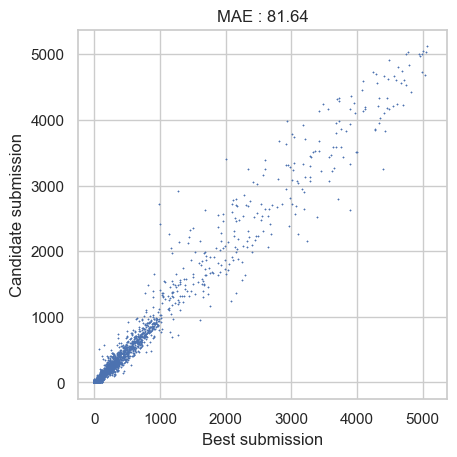

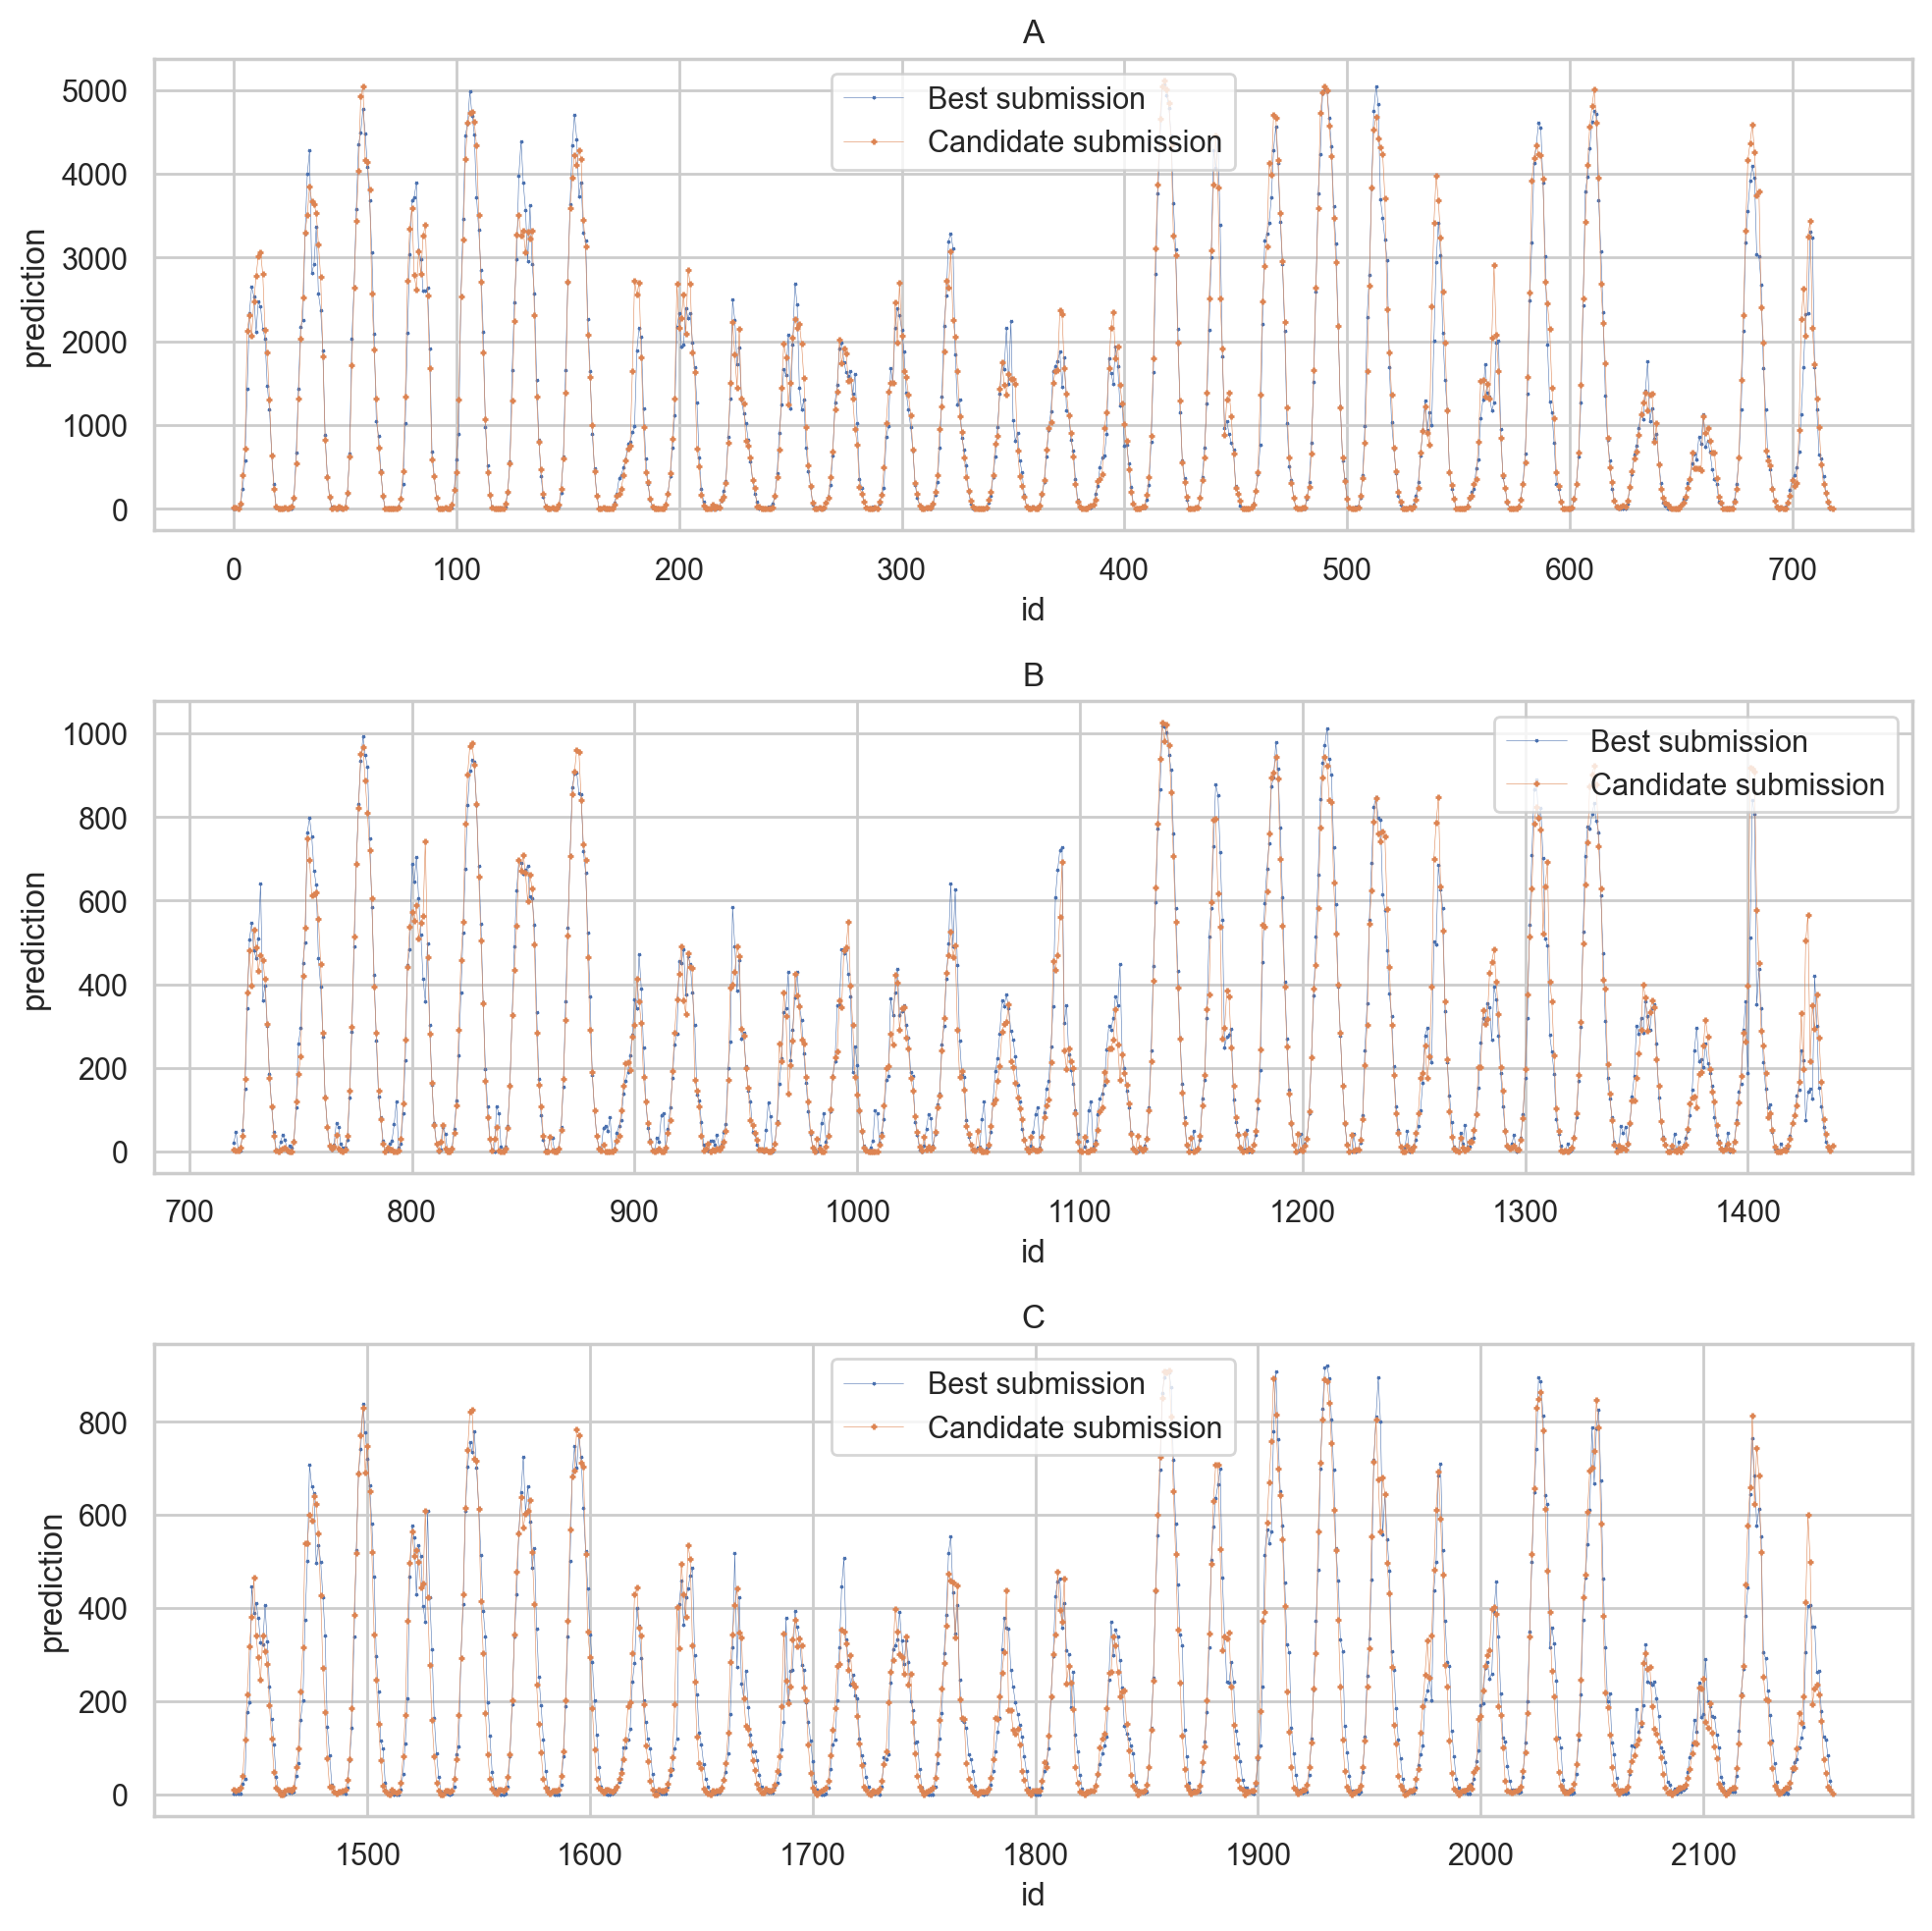

In [17]:
# Compare with previous solutions
sub1 = pd.read_csv('Submissions/catboost_kneighbor_dectree_to_lgb_lag2_minmax_old_code.csv')
sub2 = pd.read_csv('Submissions/catboost_kneighbor_dectree_to_lgb_lag4_minmax_FUTURE_v2_.csv')
name1 = "Best submission"
name2 = "Candidate submission"

mae = mean_absolute_error(sub1['prediction'],sub2['prediction'])
plt.figure()
plt.scatter(sub1['prediction'],sub2['prediction'],s=0.05,marker="*")
plt.xlabel(name1)
plt.ylabel(name2)
plt.title(f"MAE : {mae:.2f}")
# plt.xscale("log")
# plt.yscale("log")
plt.axis("square")
plt.show()

n=sub1.shape[0]//3
fig,ax = plt.subplots(nrows=3,ncols=1,figsize=(10,10),dpi=200)
for index,loc in enumerate(['A','B','C']):
    ax[index].plot(sub1['id'].iloc[index*n:(index+1)*n-1],sub1['prediction'].iloc[index*n:(index+1)*n-1],'-*',linewidth = 0.2, markersize = 0.8, label = name1)
    ax[index].plot(sub2['id'].iloc[index*n:(index+1)*n-1],sub2['prediction'].iloc[index*n:(index+1)*n-1],'-+',linewidth = 0.2, markersize = 2, label = name2)
    ax[index].set_xlabel("id")
    ax[index].set_ylabel("prediction")
    ax[index].set_title(loc)
    ax[index].legend()
fig.tight_layout()
plt.show()


### Round values in C to quantized values

In [ ]:
LOCATION = "C"
n_lagged_features = 2
threshold = 0.95

X_Train_full,Y_Train_full,X_Test_full,selected_features = full_data_loader(location = LOCATION,
                                                        n_lagged_features=n_lagged_features,
                                                        threshold=threshold,
                                                        normalization = 'minmax',
                                                        date_encoding=True,
                                                        verbose=True)
print(f"{len(selected_features)} features selected\n")

# Select the correct columns for the prediction
X_Train = X_Train_full[selected_features].astype('float32')
X_Test = X_Test_full[selected_features].astype('float32')
Y_Train = Y_Train_full['pv_measurement'].astype('float32')


In [ ]:
val_possible = np.unique(Y_Train[3::4])
len(val_possible)

sub = pd.read_csv('../Submissions/catboost_kneighbor_dectree_to_lgb_lag2_minmax_v2.csv')